In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import RecreateBiryukov
import pymc3 as pm

# Fitting to Biryukov using a precession model

## Import data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 1 to 2524
Data columns (total 18 columns):
NAME          308 non-null object
F0            308 non-null float64
F0_err        308 non-null float64
F1            308 non-null float64
F1_err        308 non-null float64
F2            308 non-null float64
F2_err        308 non-null float64
P0            308 non-null float64
P0_err        308 non-null float64
P1            308 non-null float64
P1_err        308 non-null float64
BINARY        0 non-null object
TYPE          54 non-null object
AGE           308 non-null float64
F2_rel_err    308 non-null float64
nobs          308 non-null float64
tch           308 non-null float64
tch_years     308 non-null float64
dtypes: float64(15), object(3)
memory usage: 45.7+ KB
None


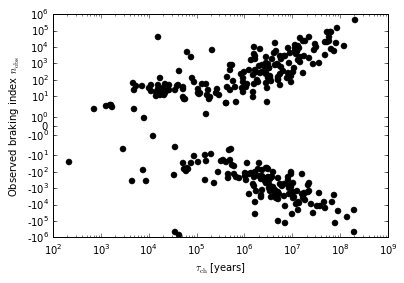

In [5]:
df = RecreateBiryukov.GetData()
tch = df['tch'].values
nobs = df['nobs'].values
P = df['P0'].values
RecreateBiryukov.NobsPlot(df)
plt.show()

## Example of what fits

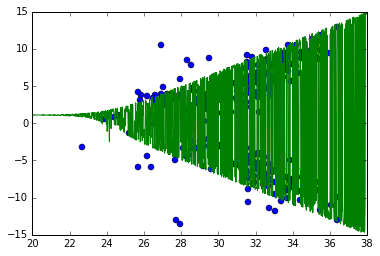

In [6]:
lognobs = np.log(np.abs(nobs)) * np.sign(nobs)
logtch = np.log(tch)
log10tch = np.log10(tch)
plt.plot(logtch, lognobs, "o")

tch_s = np.logspace(20, 38, 1000, base=np.exp(1))
logtch_s = np.log(tch_s)
nobs_s = 3 + tch_s * 1e-10 * np.cos(tch_s * 1e-6)
plt.plot(logtch_s, np.log(np.abs(nobs_s)) * np.sign(nobs_s))
plt.show()

## Define the model

In [7]:
N = len(tch)
with pm.Model() as hierarchical_model:
    # hyperparameters
    psi0 = pm.Uniform('psi0', lower=0, upper=2*np.pi, shape=N)
    zeta = pm.Normal("zeta", mu=0.0, sd=10)
    epsI = pm.HalfNormal('epsI', sd=1e-5)
    eps = pm.Uniform('eps', lower=0, upper=1e10)
    
    sin = pm.sin(2*np.pi*tch*epsI/P + psi0)
    mu =  3 + 2 * np.pi * zeta * tch * sin * epsI / P
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=eps, observed=nobs)
    
nsamples = 100000
nburn = 50000
with hierarchical_model:
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(nsamples, step, progressbar=True)

 [-----------------100%-----------------] 100000 of 100000 complete in 143.5 sec

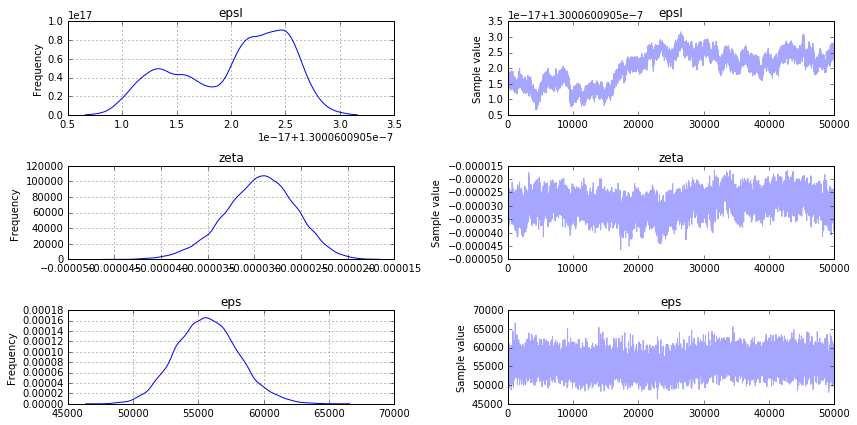

In [17]:
pm.traceplot(hierarchical_trace[nburn:], vars=['epsI', 'zeta', 'eps'])
plt.show()

### Plot a few trajectories

5742634.55513
5496053.64508
1797240.00206
6315361.92762


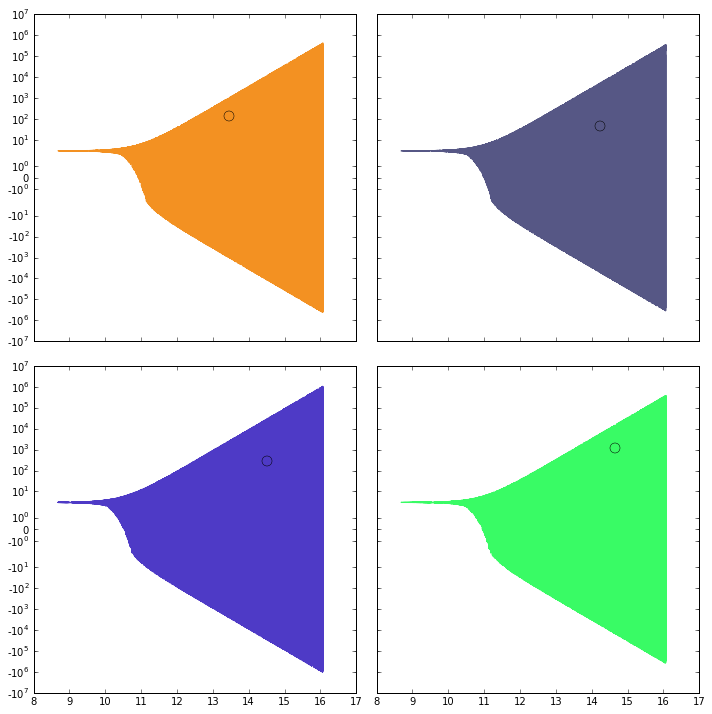

In [13]:
npp = 4
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                       sharex=True, sharey=True)

tch_s = np.logspace(20, 37, 10000, base=np.exp(1))
logtch_s = np.log(tch_s)
log10tch_s = np.log10(tch_s)

for ei, i  in enumerate(np.random.randint(0, N, npp)):
    color = np.random.uniform(0, 1, 3)
    s = hierarchical_trace[np.random.randint(nburn, nsamples)]
    tauP = P[i] / s['epsI']
    yfit =  3 + tch_s * 2 * np.pi * s['zeta'] * np.sin(2*np.pi*tch_s/tauP + s['psi0'][i])/ tauP
    ax.flat[ei].plot(log10tch_s, yfit, "-", lw=1.1, color=color)
    ax.flat[ei].plot(log10tch[i], nobs[i], "o", color=color, markersize=10)
    ax.flat[ei].set_yscale("symlog")
  
plt.tight_layout()
plt.savefig("SeveralRelisations.pdf", dpi=300)
plt.show()

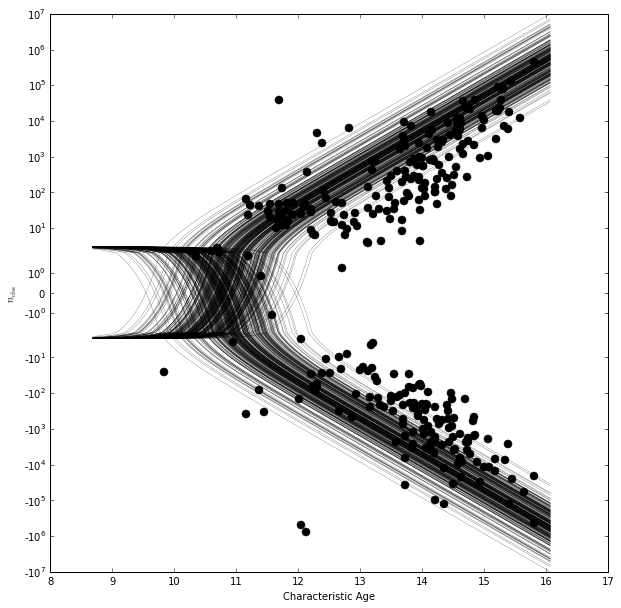

In [15]:
npp = 300
repeats = 1
fig, ax = plt.subplots(figsize=(10, 10))


tch_s = np.logspace(20, 37, 10000, base=np.exp(1))
logtch_s = np.log(tch_s)
log10tch_s = np.log10(tch_s)

for ei, i  in enumerate(np.random.randint(0, N, npp)):
    color = "k"
    for j in range(repeats):
        s = hierarchical_trace[np.random.randint(nburn, nsamples)]   
        tauP = P[i]/s['epsI']
        yfitmax = 3 + tch_s * 2 * np.pi * s['zeta'] / tauP
        ax.plot(log10tch_s, yfitmax, "-", lw=0.2, color=color)
        ax.plot(log10tch_s, -yfitmax, "-", lw=0.2, color=color)
        
ax.plot(log10tch, nobs, "o", color=color, markersize=8)

ax.set_yscale("symlog")
ax.set_xlabel("Characteristic Age")
ax.set_ylabel("$n_\mathrm{obs}$")
plt.savefig("WholeDistribution.pdf", dpi=300)
plt.show()

### The $\epsilon_I$ distribution

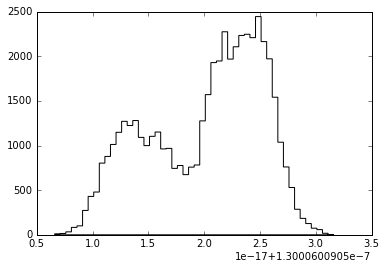

In [21]:
epsI_samples = hierarchical_trace[nburn:].get_values('epsI')
out = plt.hist(epsI_samples, bins=50, histtype="stepfilled", color="w")

This looks pretty meaningless...